In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import plotly.graph_objects as go
from typing import Tuple, Optional, NamedTuple, Any, List
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from pathlib import Path
import common
import numpy
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import activations
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


# Plan:

1. get apple data
2. clean it
3. split into train + test + validation
4. normelize it (using test scaler)
5. create basic LSTM model that can use just one stock's data
6. see how well I did

7. add other stock's data
8. check the model again (should I use the same model or a different one?)
9. think


In [8]:
apple_data = common.get_dukas_data("AAPL")
apple_data

,Local time,Open,High,Low,Close,Volume
0,01.01.2019 00:00:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
1,01.01.2019 00:01:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
2,01.01.2019 00:02:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
3,01.01.2019 00:03:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
4,01.01.2019 00:04:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
...,...,...,...,...,...,...
1736755,31.12.2018 23:55:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
1736756,31.12.2018 23:56:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
1736757,31.12.2018 23:57:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
1736758,31.12.2018 23:58:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0


In [9]:
def preprocess_data_from_dukas(df):
    
    # rename columns
    new_cols_map = {col: col.lower() for col in df}
    new_cols_map['Local time'] = "datetime"
    df = df.rename(columns=new_cols_map)

    # convert datetime type (string to datetime)
    df['datetime'] = df['datetime'].str.replace(r"\:00\.000 GMT\+0\d00","")
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y %H:%M')
    
    df = df.set_index(['datetime']).between_time("16:30", "23:00").reset_index()
    df = df.sort_values(by=['datetime'])
    
    # drop inactive days
    df['day_of_week'] = df['datetime'].dt.dayofweek
    mask = (df['day_of_week'] != 5) & (df['day_of_week'] != 6)
    df = df[mask]
    del df['day_of_week']
    df = df.reset_index(drop=True)

    return df

apple_data = preprocess_data_from_dukas(apple_data)
apple_data


,datetime,open,high,low,close,volume
0,2017-01-26 16:30:00,121.680,121.894,121.660,121.710,0.4459
1,2017-01-26 16:31:00,121.720,121.894,121.702,121.891,0.3697
2,2017-01-26 16:32:00,121.851,122.090,121.840,122.060,0.4814
3,2017-01-26 16:33:00,122.070,122.240,122.053,122.240,0.6113
4,2017-01-26 16:34:00,122.240,122.430,122.150,122.213,0.6310
...,...,...,...,...,...,...
337484,2020-05-22 22:56:00,318.317,318.538,318.238,318.438,3.4204
337485,2020-05-22 22:57:00,318.448,318.678,318.388,318.677,3.6803
337486,2020-05-22 22:58:00,318.678,318.918,318.638,318.818,3.8403
337487,2020-05-22 22:59:00,318.818,319.168,318.688,318.688,3.5204


In [10]:
PREDICTION_RANGE = 10
apple_data['target'] = apple_data['close'].shift(-PREDICTION_RANGE)
apple_data.dropna(inplace=True)
apple_data

,datetime,open,high,low,close,volume,target
0,2017-01-26 16:30:00,121.680,121.894,121.660,121.710,0.4459,122.053
1,2017-01-26 16:31:00,121.720,121.894,121.702,121.891,0.3697,121.973
2,2017-01-26 16:32:00,121.851,122.090,121.840,122.060,0.4814,122.030
3,2017-01-26 16:33:00,122.070,122.240,122.053,122.240,0.6113,121.990
4,2017-01-26 16:34:00,122.240,122.430,122.150,122.213,0.6310,122.033
...,...,...,...,...,...,...,...
337474,2020-05-22 22:46:00,318.237,318.285,318.098,318.178,2.9602,318.438
337475,2020-05-22 22:47:00,318.178,318.197,317.978,318.038,2.4803,318.677
337476,2020-05-22 22:48:00,318.018,318.155,317.997,318.138,2.3202,318.818
337477,2020-05-22 22:49:00,318.137,318.138,317.757,317.897,2.1402,318.688


In [11]:
# i will start using only close prices
apple_close_price = apple_data[['close', 'volume']].values
apple_targets = apple_data['target'].values.reshape(-1, 1)

In [43]:
def train_val_test_split(samples, features) -> Tuple[np.array, np.array, np.array, np.array]:
    X_train, X_test, y_train, y_test = train_test_split(samples, features, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(apple_close_price, apple_targets)

<module 'matplotlib.pyplot' from '/Users/alon/opt/anaconda3/envs/data_science/lib/python3.7/site-packages/matplotlib/pyplot.py'>

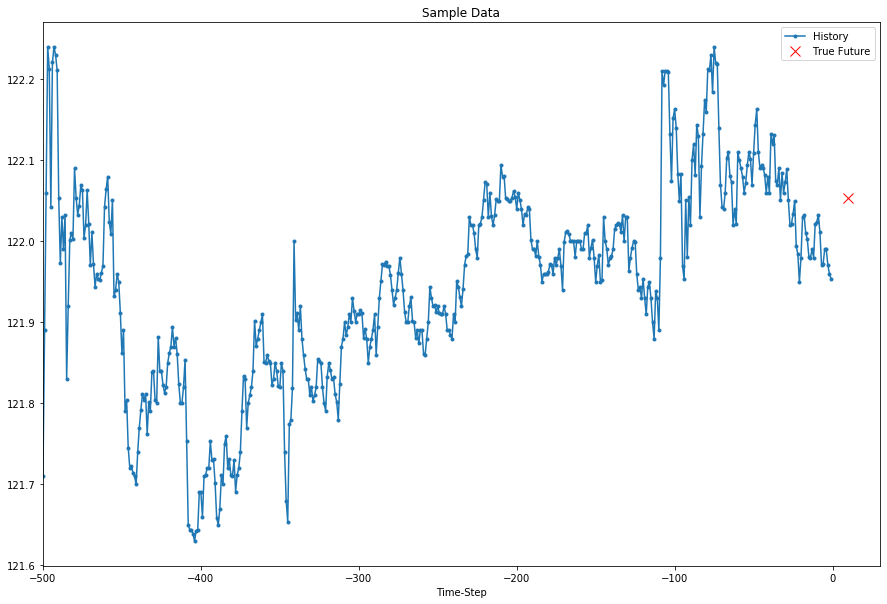

In [44]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(title, features: np.array, target: np.float64, prediction=None, delta=None):
    plt.figure(figsize=(15, 10))
    
    plot_data = [features, target]
    if prediction:
        plot_data.append(prediction)
        
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(
            ), marker[i], label=labels[i])
            
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


show_plot("Sample Data", X_train[:500, 0], y_train[0], delta=PREDICTION_RANGE)

In [45]:
# normelize the data, using the training set
def normelize_data(*arrays) -> Tuple[List, Any, Any]:
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    x_scaler.fit(arrays[0]) # X_train must be first!
    y_scaler.fit(arrays[1]) # y_train must be second!
    data = [y_scaler.transform(arr) if arr.shape[1] == 1 else x_scaler.transform(arr) for arr in arrays]
    data.extend([x_scaler, y_scaler])
    return data


X_train, y_train, X_val, y_val, X_test, y_test, x_scaler, y_scaler = normelize_data(X_train, y_train, X_val, y_val, X_test, y_test)


In [91]:
DAYS_BACK = 500
BATCH_SIZE = 256


def get_data_and_targets(x_values, y_values, look_back_periods=DAYS_BACK):
    samples = []
    targets = []
    for i in range(look_back_periods, len(x_values)):
        indices = range(i-look_back_periods, i)
        samples.append(x_values[indices])
        targets.append(y_values[i])
    
    return np.array(samples), np.array(targets)



train_data = tf.data.Dataset.from_tensor_slices(get_data_and_targets(X_train, y_train))
train_data = train_data.cache().shuffle(len(X_train)).batch(BATCH_SIZE).repeat().prefetch(5)

val_data = tf.data.Dataset.from_tensor_slices(get_data_and_targets(X_val, y_val)).batch(BATCH_SIZE).repeat().prefetch(5)
test_data = tf.data.Dataset.from_tensor_slices(get_data_and_targets(X_test, y_test)).batch(BATCH_SIZE).repeat().prefetch(5)




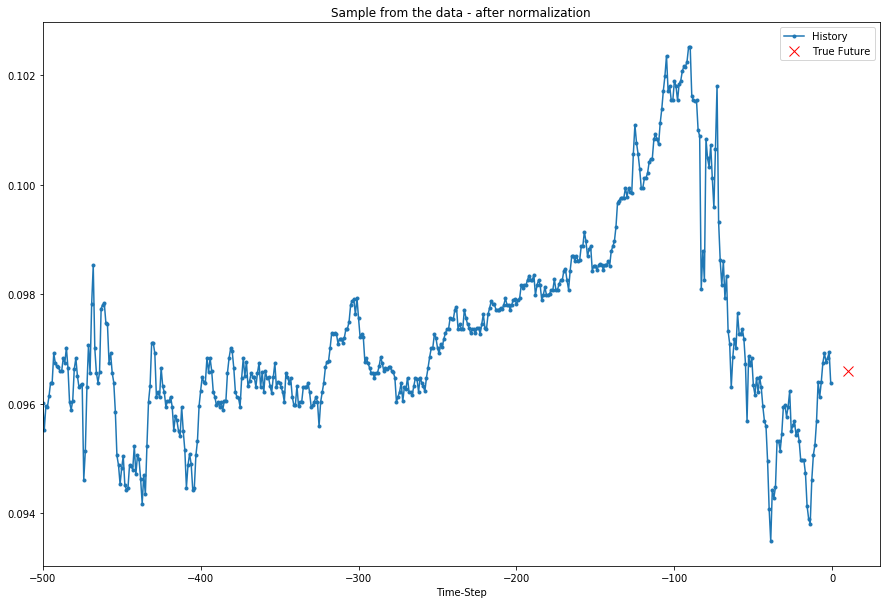

In [92]:
for x, y in train_data.take(1):
    show_plot("Sample from the data - after normalization", x.numpy()[0][:, 0], y[0][0], delta=PREDICTION_RANGE)

In [98]:
# define the checkpoint
filepath="weights-improvement-datasets-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

# tensorboard
log_dir = "logs/fit/v5/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)


callbacks_list = [checkpoint, tensorboard_callback]


lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=x.shape[1:]))
lstm_model.add(Dense(1))
lstm_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1), loss='mse')

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


In [99]:
# !rm -rf ./logs/ 
    
lstm_model.fit(
    train_data,epochs=20, steps_per_epoch=150,
                      validation_data=val_data, validation_steps=50, callbacks=callbacks_list)


Train for 150 steps, validate for 50 steps
Epoch 1/20
149/150 [============================>.] - ETA: 2s - loss: 0.0755
Epoch 00001: loss improved from inf to 0.07500, saving model to weights-improvement-datasets-01-0.0750.hdf5
150/150 [==============================] - 353s 2s/step - loss: 0.0750 - val_loss: 4.9485e-04
Epoch 2/20
149/150 [============================>.] - ETA: 2s - loss: 2.4295e-04
Epoch 00002: loss improved from 0.07500 to 0.00024, saving model to weights-improvement-datasets-02-0.0002.hdf5
150/150 [==============================] - 345s 2s/step - loss: 2.4186e-04 - val_loss: 3.5708e-05
Epoch 3/20
149/150 [============================>.] - ETA: 2s - loss: 3.9147e-05
Epoch 00003: loss improved from 0.00024 to 0.00004, saving model to weights-improvement-datasets-03-0.0000.hdf5
150/150 [==============================] - 360s 2s/step - loss: 3.9066e-05 - val_loss: 2.1072e-05
Epoch 4/20
149/150 [============================>.] - ETA: 2s - loss: 2.8991e-05
Epoch 00004: lo

In [ ]:
lstm_model.save("lstm_model_v1")


In [100]:
from tensorflow import keras
model = keras.models.load_model('weights-improvement-datasets-19-0.0000.hdf5')

<module 'matplotlib.pyplot' from '/Users/alon/opt/anaconda3/envs/data_science/lib/python3.7/site-packages/matplotlib/pyplot.py'>

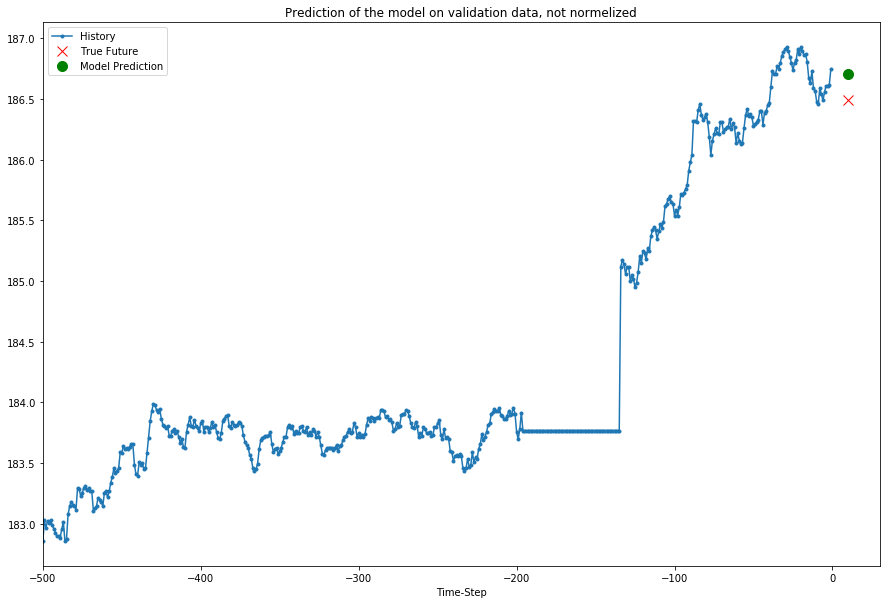

In [24]:
batch0 = val_generator[0]
x, y = batch0
sample = batch0[0][0]
target = batch0[1][0]
sample = sample.reshape((1, *sample.shape))
prediction = model.predict(sample)
# show_plot("Prediction of the model on validation data", x[0][:, 0], y[0][0], prediction=prediction, delta=PREDICTION_RANGE)

x = x_scaler.inverse_transform(x[0])
y = y_scaler.inverse_transform(y)
prediction = y_scaler.inverse_transform(prediction)
show_plot("Prediction of the model on validation data, not normelized", x[:, 0], y[0][0], prediction=prediction, delta=PREDICTION_RANGE)


In [66]:
def pnl_using_price(curr_price, predicted_price, true_price):    
    predicted_roc = predicted_price / curr_price - 1
    true_roc = true_price / curr_price - 1
    return rate_of_change_PnL(predicted_roc, true_roc)


# from common.py - will return a vector of profits/losses (percentage wise) for every trade
def rate_of_change_PnL(pred_roc, actual_roc):
    """ calculate the profit/loss of every prediction """
    return (pred_roc > 0) * actual_roc - (pred_roc < 0) * actual_roc


# checking how well the model did:
# some_batches = [i for i in val_generator][:2]
pnls = []
for batch in val_generator:
    samples, targets = batch
    predictions = model.predict(samples)
    for sample, target, prediction in zip(samples, targets, predictions):
#         last_known_price = sample[-1][0]
#         if prediction[0] > last_known_price:
#             buy = True
#         else:
#             buy = False
        
        original_last_price_point = x_scaler.inverse_transform(sample)[:, 0][-1]
        original_prediction = y_scaler.inverse_transform(prediction.reshape(1, 1))[0][0]
        original_target = y_scaler.inverse_transform(target.reshape(1, 1))[0][0]
#         rate_of_change = abs((original_target - original_last_price_point) / original_last_price_point)
#         if buy and original_last_price_point < original_target:
#             wins.append(rate_of_change)
#         elif not buy and original_last_price_point > original_target:  # short
#             wins.append(rate_of_change)
#         elif buy and original_last_price_point > original_target:
#             losses.append(rate_of_change)
#         elif not buy and original_last_price_point < original_target:
#             losses.append(rate_of_change)
        pnls.append(pnl_using_price(original_last_price_point, original_prediction, original_target))
        
            
            
def mean(l: list) -> float:
    return sum(l) / len(l)

print(f"pnl average: {mean(pnls)}")


pnl average: 3.8254342691428704e-05


In [76]:
# whats the PnL if I just buy and hold? 
# first_price_point = X_val[0]
# last_price_point = X_val[-1]
# pnl_using_price()
original_X_val = x_scaler.inverse_transform(X_val)
first_price_point = original_X_val[0][0]
last_price_point = original_X_val[-1][0]
print(f"Pnl of Buy & Hold strategy: {pnl_using_price(first_price_point, 1000000, last_price_point)}")


Pnl of Buy & Hold strategy: 0.3975520929668912


In [4]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

# tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


callbacks_list = [checkpoint, tensorboard_callback]

In [ ]:
training_indexes = np.random.choice(len(examples), size=100, replace=False)
training_examples, training_targets = examples[training_indexes], targets[training_indexes]

In [ ]:
model.fit(training_examples, 
          training_targets, 
          epochs=20, 
          batch_size=10, 
          callbacks=callbacks_list)